# Kaggle Submission Notebook
## W207 Final Project
### T. P. Goter
### July 26, 2019

This workbook is used to generate predictions on the Kaggle-provided test data and generate some files that can be submitted and scored on Kaggle. This is the final test of our models' accuracies.

In [2]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
tf.__version__
tf.keras.backend.clear_session()

## Regenerate the KNR model for official scoring

In [97]:
def knr(k=5, test_X=test_X):

    # Let's create our knn classifier
    knn_model = KNeighborsRegressor(n_neighbors=k)
    
    df = pd.read_pickle('df_nostache_nonan.pkl')
    
    train_X = df['Image'].map(lambda x: x.astype(int) / 255.0)
    train_X = np.array([x for x in train_X])
    train_y = np.array(df.iloc[:,:-1])
    knn_model.fit(train_X, train_y)
    
    # Generate predictions
    test_X = np.array([x.reshape(9216) for x in test_X])
    test_y = knn_model.predict(test_X)
    
    # Throw the predictions in a dataframe
    pred_df = pd.DataFrame(test_y, columns=keypoints)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    name = 'knn'
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)
    
    
    return knn_model


## Recreate model because Keras is broken

When specifying the input shape using the Input Layer (as opposed to as part of the first convolution layer) the h5 file saved through the model.save() method in keras will not have the appropriate shape information saved to it. Thus, to actually load these saved models, one needs to rebuild their model (hopefully they remember all the details) and then just bring in the weights from the saved model.

### The function below recreates the models for most of our higher performing AlexNet architecture.

In [4]:
def create_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

### Recreate our VGG Net Models

In [6]:
def create_vgg_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    
    # Input layer is our grayscale image that is 96 pixels by 96 pixels
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Add our first convolution layers which is two back-to-back conv with 3x3 kernel and same padding
    # Add depth with filters
    # Our output from these convolutions will be (96,96,start_filter)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (48,48,32)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Add our second convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth - output layer will be (48,48,start_filter*2)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (24,24,start_filter*2)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    
    # Add our third convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (24,24,start_filter*4)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (12,12,start_filter*4)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Add our fourth and final convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (12,12,start_filter*8)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (6,6,start_filter*8)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

### Recreate our Specialist Models

In [21]:
def create_spec_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

## Generate our KNR model

In [98]:
knn_model = knr()

## Load our Alex Net Model

In [5]:
# Need to rebuild our model - keras won't let us load the model directly due to a bug
model = create_bn_cnn_model(start_filter=12, d=0.0, step=0.00)

# Path to the model - we will just load the weights from it
model_path = 'Models/cnn_lr_adam_d0.0_s0.0_sf12_lrfactor10.h5' 

# Load the weights in
model.load_weights(model_path, by_name=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 12)        0         
_________________________________________________________________
dropout (Dropout)            (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 24)        0

### Load a VGG Net Model

In [103]:
# Need to rebuild our model - keras won't let us load the model directly due to a bug
vgg_model = create_vgg_model(start_filter=16, d=0.0, step=0.02, bias=False)

# Path to the model - we will just load the weights from it
model_path = 'Models/cnn_vgg_flipped4_model_adam_d0.0_s0.02_sf16.h5' 

# Load the weights in
vgg_model.load_weights(model_path)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 96, 96, 16)        144       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization_15 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 32)        4608      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 32)       

## Load the test data 

The test data is a set of 1700+ images. We apparently don't need predictions for all keypoints for every image. There is a look up table with the appropriate RowId, ImageId and Feature to be predicted. So we will generate all of the predictions and then filter our data before writing the submission file.

In [7]:
# Test Data is just Image ID followed by an array of pixel values. 
test_data = pd.read_csv('facial-keypoints-detection/test.csv')

# Display the first few lines of data
print(test_data.head(5))

# Scale the test data for our model
test_X = test_data['Image'].map(lambda x: (np.array(x.split()).astype(int) / 255.0))

# Get the data ready for predicting
test_X = np.array([x.reshape(96,96,1) for x in test_X])

# Look at our array
print(test_X.shape)

# Read in the lookup data
look_up = pd.read_csv('facial-keypoints-detection/IdLookupTable.csv')

# Read in the column headers from the training dataset
df = pd.read_csv('facial-keypoints-detection/training.csv')
keypoints = df.columns[:-1]
X = df['Image'].map(lambda x: (np.array(x.split()).astype(int) / 255.0))
del df

   ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
(1783, 96, 96, 1)


## Recreate our Specialist Models and load the weights


In [25]:
specialist_models = {}
for keypoint in keypoints[::2]:
    # Rebuild the model
    specialist_models[keypoint[:-2]] = create_spec_bn_cnn_model(12, 0, 0.1)
    
    # Get path to current specialist
    spec_model_path = 'Models/cnn_spec_'+keypoint[:-2]+'_d0_s10_sf12_lrfactor1_flipped_100.h5' 

    # Load the weights in
    specialist_models[keypoint[:-2]].load_weights(spec_model_path)
print(specialist_models.keys())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_95 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_96 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_110 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_111 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_125 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_126 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_140 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_141 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_155 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_156 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 23, 23, 24)      

## Generate predictions from our model and write submissions file

In [8]:
def predict_submit(model, name='sf12_do0_0_noflip'):
    '''
    This function takes an input model, generates predictions on our test data, and 
    writes a file to be submitted to Kaggle for scoring.
    '''
    # Make our predictions
    test_y = model.predict(test_X)
    
    # Throw the predictions in a dataframe
    pred_df = pd.DataFrame(test_y, columns=keypoints)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)

## Generate predictions from specialist models and write submissions file

In [32]:
def predict_submit_spec(model_dict, name='spec01'):
    '''
    This function takes an input model, generates predictions on our test data, and 
    writes a file to be submitted to Kaggle for scoring.
    '''
    pred_df = pd.DataFrame()
    for key, model in model_dict.items():
    
        # Make our predictions
        test_y = model.predict(test_X)
    
        # Throw the predictions in a dataframe
        temp_df = pd.DataFrame(test_y, columns=[key+'_x', key+'_y'])
        
        # Eliminate negatives and replace with zero
        temp_df[key+'_x'] = temp_df[key+'_x'].map(lambda x: 0 if x < 0 else x)
        temp_df[key+'_y'] = temp_df[key+'_y'].map(lambda x: 0 if x < 0 else x)
        
        # Concatenate the temporary dataframe to the prediction dataframe
        pred_df = pd.concat([pred_df, temp_df], axis=1)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)

In [33]:
predict_submit_spec(specialist_models)

In [101]:
predict_submit(vgg_model, name='vgg_sf12_do0_0_noflip')

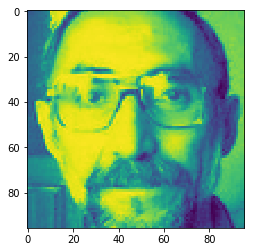

In [19]:
plt.imshow(test_X[-100].reshape(96,96))